# OCR Project 2: Scanner + OCR

# Importing the libraries

In [ ]:
import numpy as np
import cv2
import imutils
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -R /content/gdrive/MyDrive/Cursos\ -\ recursos/OCR\ with\ Python/Images/Images\ Project\ 2 images/

In [ ]:
def show_img(img):
  fig = plt.gcf()
  fig.set_size_inches(20, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# Pre-processing the image

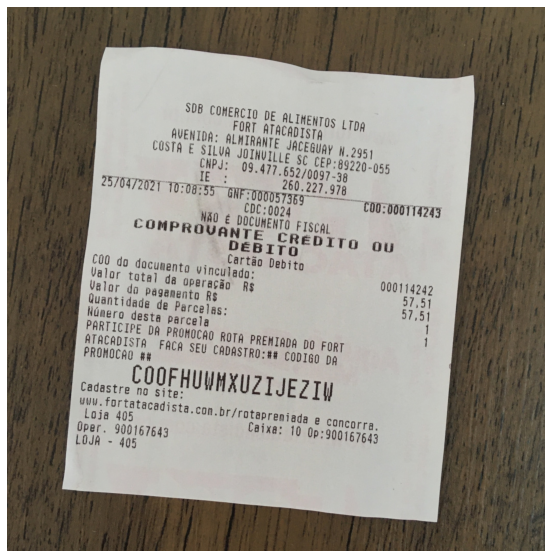

1061 1049


In [ ]:
img = cv2.imread('/content/images/doc_rotated01.jpg')
original = img.copy()
show_img(img)
(H, W) = img.shape[:2]
print(H, W)

## Grayscale

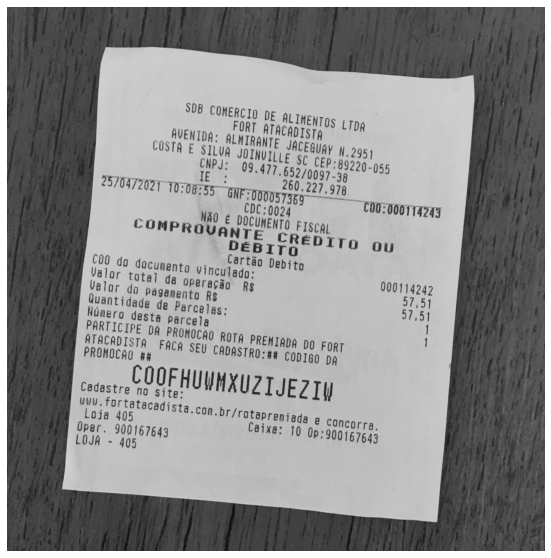

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img(gray)

## Gaussian Blur

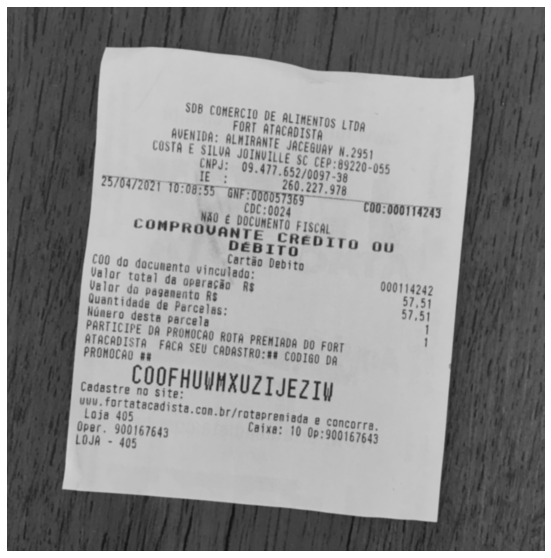

In [ ]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
show_img(blur)

## Border detection (*Canny Edge*)

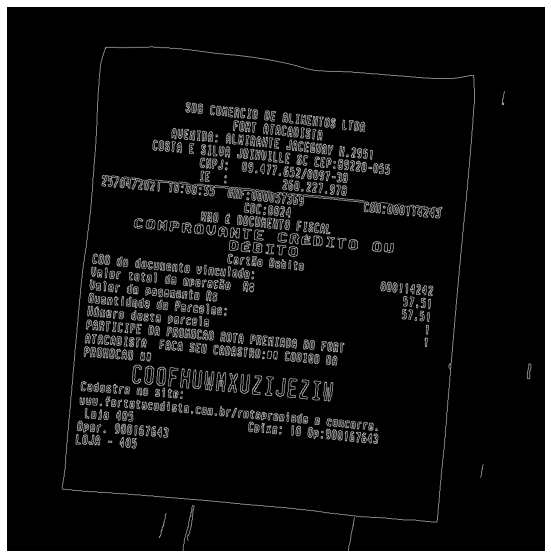

In [ ]:
edged = cv2.Canny(blur, 60, 160)
show_img(edged)

# Contours detection

In [ ]:
def find_contours(img): # EXTERNAL
  conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
  return conts

In [ ]:
conts = find_contours(edged.copy())

In [ ]:
conts

[array([[[278,  77]],
 
        [[277,  78]],
 
        [[250,  78]],
 
        ...,
 
        [[300,  78]],
 
        [[285,  78]],
 
        [[284,  77]]], dtype=int32), array([[[277,  78]],
 
        [[278,  77]],
 
        [[284,  77]],
 
        ...,
 
        [[246,  79]],
 
        [[249,  79]],
 
        [[250,  78]]], dtype=int32), array([[[298, 702]],
 
        [[296, 704]],
 
        [[295, 704]],
 
        [[294, 705]],
 
        [[294, 707]],
 
        [[293, 708]],
 
        [[293, 719]],
 
        [[292, 720]],
 
        [[292, 729]],
 
        [[291, 730]],
 
        [[291, 731]],
 
        [[292, 732]],
 
        [[292, 734]],
 
        [[295, 737]],
 
        [[296, 737]],
 
        [[297, 738]],
 
        [[301, 738]],
 
        [[302, 737]],
 
        [[304, 737]],
 
        [[307, 734]],
 
        [[307, 731]],
 
        [[308, 730]],
 
        [[308, 722]],
 
        [[309, 721]],
 
        [[309, 710]],
 
        [[310, 709]],
 
        [[309, 708]],
 
        [[

## Locatting the biggest contour

- Douglas-Peucker: http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm

In [ ]:
from re import A
for c in conts:
  perimeter = cv2.arcLength(c, True)
  approximation = cv2.approxPolyDP(c, 0.02 * perimeter, True)
  if len(approximation) == 4:
    larger = approximation
    break

In [ ]:
larger

array([[[ 192,   78]],

       [[ 108,  940]],

       [[ 838, 1004]],

       [[ 909,  133]]], dtype=int32)

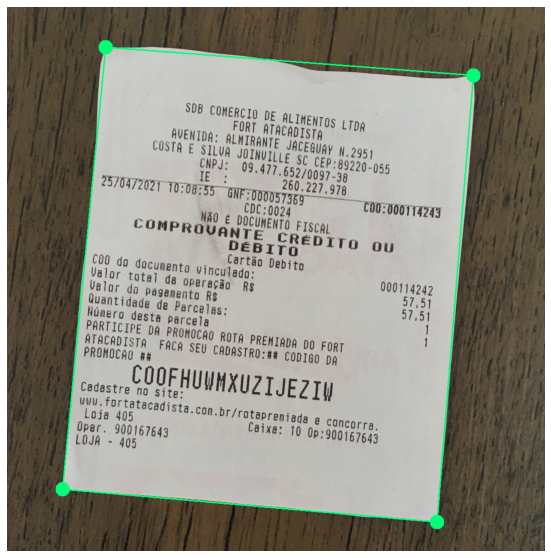

In [ ]:
cv2.drawContours(img, larger, -1, (120,255,0), 28)
cv2.drawContours(img, [larger], -1, (120,255,0), 2)
show_img(img)

## Sorting the points

- top left
- top right
- bottom right
- bottom left

In [ ]:
def sort_points(points):
  points = points.reshape((4,2))
  #print(points.shape)
  new_points = np.zeros((4, 1, 2), dtype=np.int32)
  #print(new_points.shape)
  #print(new_points)
  add = points.sum(1)
  #print(add)

  new_points[0] = points[np.argmin(add)]
  new_points[2] = points[np.argmax(add)]
  dif = np.diff(points, axis = 1)
  new_points[1] = points[np.argmin(dif)]
  new_points[3] = points[np.argmax(dif)]
  #print(new_points)

  return new_points

In [ ]:
larger

array([[[ 192,   78]],

       [[ 108,  940]],

       [[ 838, 1004]],

       [[ 909,  133]]], dtype=int32)

In [ ]:
192 + 78, 108 + 940

(270, 1048)

In [ ]:
points_larger = sort_points(larger)
print(points_larger)

[[[ 192   78]]

 [[ 909  133]]

 [[ 838 1004]]

 [[ 108  940]]]


## Transformation matrix

In [ ]:
pts1 = np.float32(points_larger)
pts1

array([[[ 192.,   78.]],

       [[ 909.,  133.]],

       [[ 838., 1004.]],

       [[ 108.,  940.]]], dtype=float32)

In [ ]:
print(W, H)

1049 1061


In [ ]:
pts2 = np.float32([[0,0], [W, 0], [W, H], [0, H]])
pts2

array([[   0.,    0.],
       [1049.,    0.],
       [1049., 1061.],
       [   0., 1061.]], dtype=float32)

In [ ]:
matrix = cv2.getPerspectiveTransform(pts1, pts2)
matrix

array([[ 1.47103022e+00,  1.43348652e-01, -2.93618997e+02],
       [-9.58731834e-02,  1.24983768e+00, -7.90796880e+01],
       [ 1.08773828e-05,  2.32288006e-05,  1.00000000e+00]])

## Perspective transformation

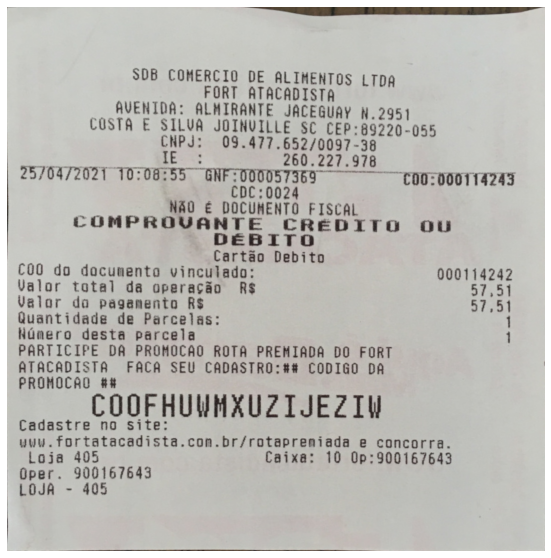

In [ ]:
transform = cv2.warpPerspective(original, matrix, (W, H))
show_img(transform)

# OCR with Tesseract

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,323 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import pytesseract

In [ ]:
!mkdir tessdata
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true

mkdir: cannot create directory ‘tessdata’: File exists
--2022-04-07 15:55:18--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2022-04-07 15:55:18--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2022-04-07 15:55:18--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

In [ ]:
config_tesseract = "--tessdata-dir tessdata"

In [ ]:
text = pytesseract.image_to_string(transform, lang='por', config=config_tesseract)
print(text)

SDB COMERCIO DE ALIMENTOS LTDA
FORT ATACADISTA
AVENIDA: ALMIRANTE JACEGUAY N.2951
COSTA E SILVA JOINUILLE SC CEP:89220-055
CNPJ: 09.477.652/0097-38
7 SRAm 260.227.978

2570972027 T0:08:55" Gnrzggvgãzgsà““““'** ***** CO0T0001142A3

NÃO É DOCUMENTO FISCAL
COMPROUANTE CREDITO OU

DÉBIT

Cartão Debito
COO do documento vinculado: 000114242
Valor total da operação R$ 55l
Valor do pagamento R$ BTAA
Quantidade de Parcelas:
Núnmnero desta parcela 1

PARTICIFE DA PROMOCAO ROTA PREMIADA DO FORT
ATACADISTA FACA SEU CADASTRO:%% CODIGO DA
PROMOCAO &%

COOFHUWMXUZIJEZIV

Cadastre no site:
uuu.fortatacadista.con.br/rotapreniada e concorra.
Loja 405 Caixa: 10 0p:900167643
Oper. 900167643
LOJA - 405

 



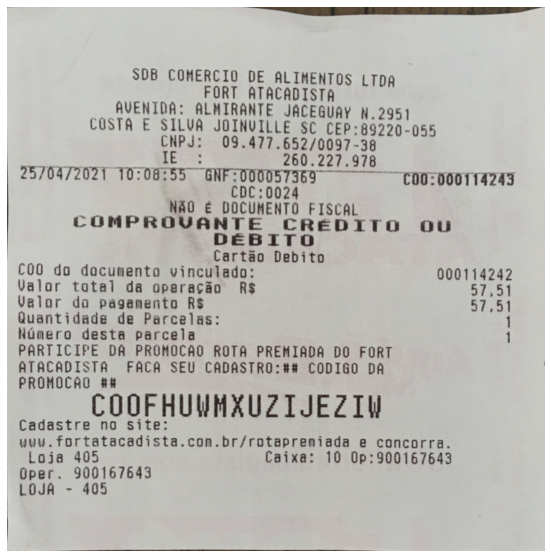

In [ ]:
increase = cv2.resize(transform, None, fx=1.5, fy = 1.5, interpolation=cv2.INTER_CUBIC)
show_img(increase)

In [ ]:
text = pytesseract.image_to_string(increase, lang='por', config=config_tesseract)
print(text)

SDB COMERCIO DE ALIMENTOS LTDA
FORT ATACADISTA
AVENIDA: ALMIRANTE JACEGUAY N.2951

COSTA E SILVA JOINVILLE SC CEP:89220-055

CNPJ: 09.477.652/0097-38
al o ES RAA 11

zmmnw1mm&s*wqªªg?r“ TU0 000114283
NÃO É DOCUMENTO FISCAL

COMPROVANTE CRÉDITO OU

DÉEÉBITO

Cartão Debito
C0OO0 do documento vincutado: 000114242
Valor total da operação R$ BT
Valor do pagamento R$ B1A
Quantidade de Parcelas: 1
Número desta parcela 1

PARTICIPE DA PROMOCAO ROTA PREMIADA DO FORT
ATACADISTA FACA SEU CADASTRO:&%&% CODIGO DA
PROMOCÃAO h%

COOFHUWMXUZIJEZIMV

Cadastre no site:
uuuw.fortatacadista.con.br/rotaprenmniada e concorra.
Loja 405 Caixa: 10 0p:900167643
Oper. 900167643
LOJA - 405



# Improving image quality

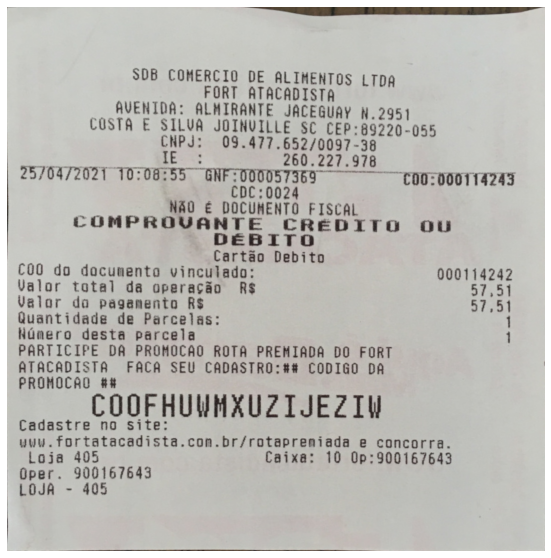

In [ ]:
show_img(transform)

## Increasing brightness and contrast

In [ ]:
transform.shape

(1061, 1049, 3)

In [ ]:
brightness = 50
contrast = 80
adjust = np.int16(transform)
adjust.shape

(1061, 1049, 3)

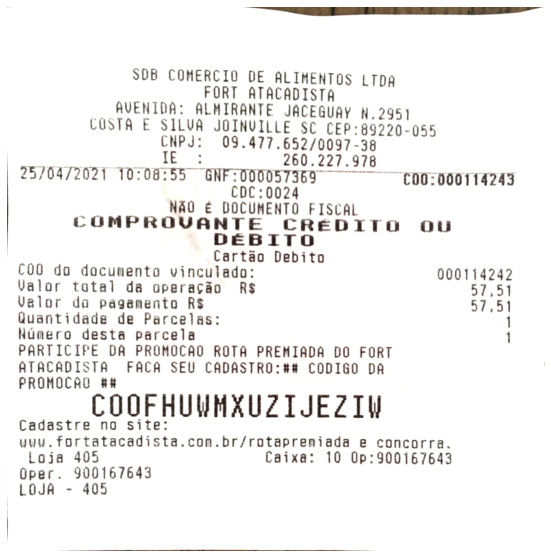

In [ ]:
adjust = adjust * (contrast / 127 + 1) - contrast + brightness
adjust = np.clip(adjust, 0, 255)
adjust = np.uint8(adjust)
show_img(adjust)

## Adaptive thresholding

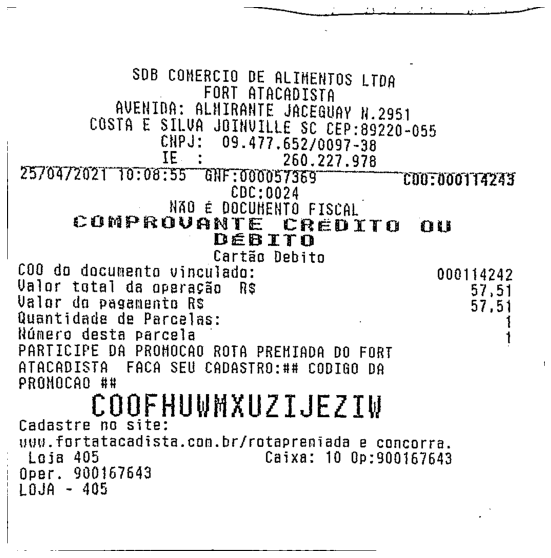

In [ ]:
processed_img = cv2.cvtColor(transform, cv2.COLOR_BGR2GRAY)
processed_img = cv2.adaptiveThreshold(processed_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
show_img(processed_img)

## Removing edges

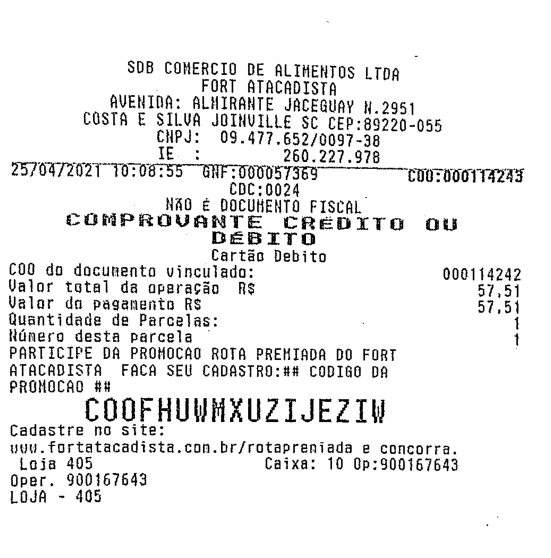

In [ ]:
margin = 18
img_edges = processed_img[margin:H - margin, margin:W - margin]
show_img(img_edges)

## Comparison

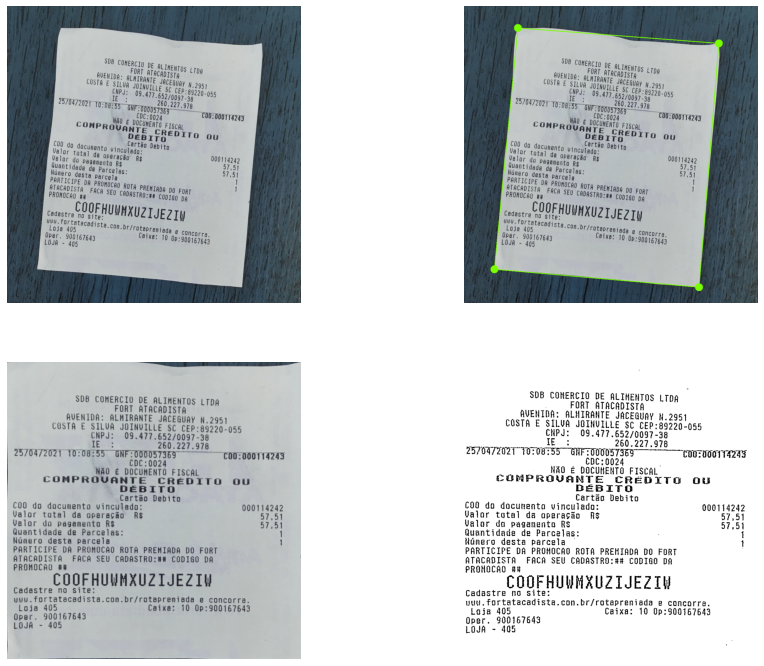

In [ ]:
fig, im = plt.subplots(2, 2, figsize=(15,12))
for x in range(2):
  for y in range(2):
    im[x][y].axis('off')
im[0][0].imshow(original)
im[0][1].imshow(img)
im[1][0].imshow(transform, cmap='gray')
im[1][1].imshow(img_edges, cmap='gray')
plt.show();

# Putting all together

In [ ]:
def transform_image(image_file):
  img = cv2.imread(image_file)
  original = img.copy()
  show_img(img)
  (H, W) = img.shape[:2]

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (7, 7), 0)
  edged = cv2.Canny(blur, 60, 160)
  show_img(edged)
  conts = find_contours(edged.copy())
  for c in conts:
    peri = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(aprox) == 4:
      larger = aprox
      break

  cv2.drawContours(img, larger, -1, (120, 255, 0), 28)
  cv2.drawContours(img, [larger], -1, (120, 255, 0), 2)
  show_img(img)

  points_larger = sort_points(larger)
  pts1 = np.float32(points_larger)
  pts2 = np.float32([[0, 0], [W, 0], [W, H], [0, H]])

  matrix = cv2.getPerspectiveTransform(pts1, pts2)
  transform = cv2.warpPerspective(original, matrix, (W, H))

  show_img(transform)
  return transform

In [ ]:
def process_img(img):
  processed_img = cv2.resize(img, None, fx=1.6, fy=1.6, interpolation=cv2.INTER_CUBIC)
  processed_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  processed_img = cv2.adaptiveThreshold(processed_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
  return processed_img

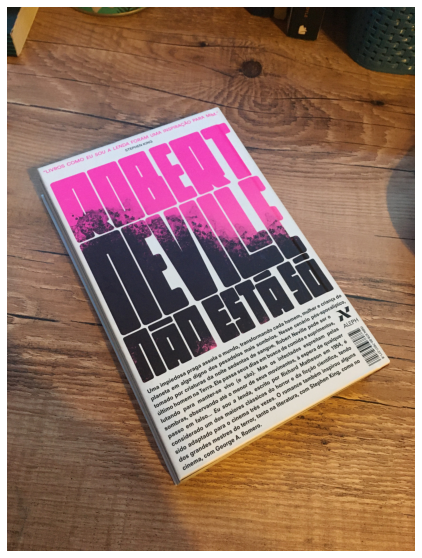

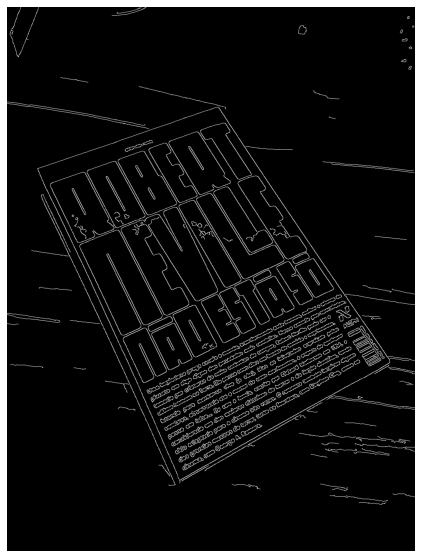

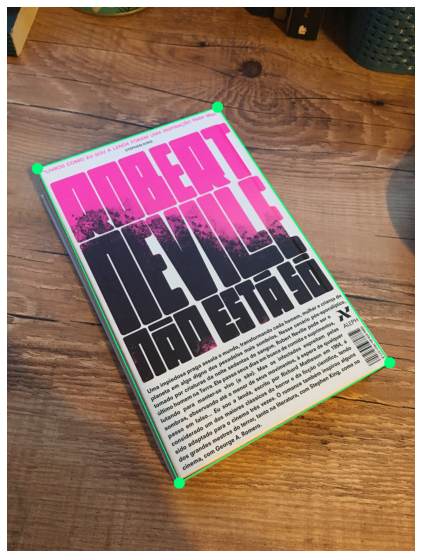

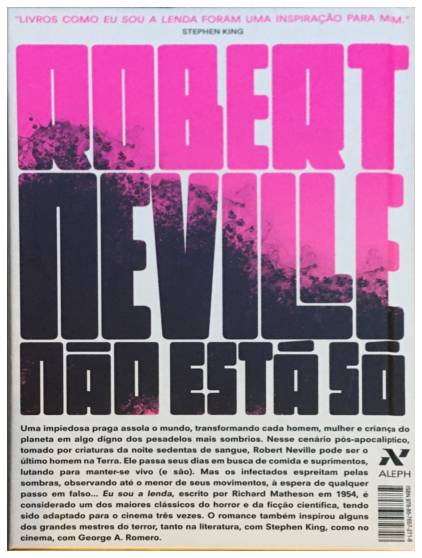

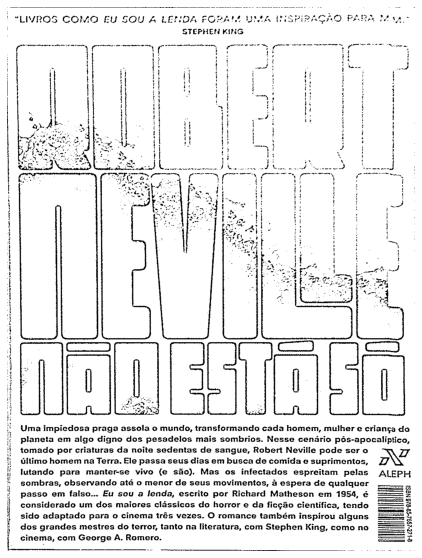

In [ ]:
img = transform_image('/content/images/book1.jpg')
img = process_img(img)
show_img(img)